

****

Be mindful of :
- label smoothing 
- loss on proba or log probas


**Data :**
*WalkingSittingStanding* from [UAE](https://www.timeseriesclassification.com/description.php?Dataset=WalkingSittingStanding)

For reference, a MiniRocket classifier gets accuracy of 92.7% on the default test data.

Best so far : 60 % accuracy

- the loss function does not have a smooth profile 
- parameter tuning on the optimisation and, size, number of channels and loss parameters

In [1]:
import os
from aeon.datasets import load_from_tsfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

import random

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Load data

In [4]:
data_dir = os.path.join(os.getcwd(), "..", "data", "WalkingSittingStanding")
train_file = "WalkingSittingStanding_TRAIN.ts"
test_file = "WalkingSittingStanding_TEST.ts"

In [5]:
tsx_train, y_train_labels = load_from_tsfile(os.path.join(data_dir, train_file))
tsx_test, y_test_labels = load_from_tsfile(os.path.join(data_dir, test_file))
# Convert labels to one-hot encoded vectors


def to_one_hot(y, num_classes=6):
    return np.eye(num_classes)[y.astype(int)]


# Convert to soft probabilities
def to_soft_probabilities(y_one_hot, temperature=0.2):
    exp_values = np.exp(y_one_hot / temperature)
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)


# Apply transformations
y_train = to_soft_probabilities(to_one_hot(y_train_labels.astype(float)))
y_test = to_soft_probabilities(to_one_hot(y_test_labels.astype(float)))

tsx_train = Tensor(tsx_train).swapaxes(1, 2).to(device)
tsx_test = Tensor(tsx_test).swapaxes(1, 2).to(device)

# Convert back to PyTorch tensors
y_train = torch.logit(torch.tensor(y_train, dtype=torch.float32)).to(device)
y_test = torch.logit(torch.tensor(y_test, dtype=torch.float32)).to(device)
tsx_train.shape, len(y_test)

(torch.Size([7352, 206, 3]), 2947)

In [6]:
tsx_train.shape, y_train.shape

(torch.Size([7352, 206, 3]), torch.Size([7352, 6]))

## Benchmark with a logistic regression

In [73]:
torch.flatten(tsx_train, start_dim=1)

tensor([[ 0.1904,  0.7879,  0.5734,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6126, -0.2801, -0.2693,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0204, -0.0802, -0.0709,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.7765,  0.5001,  0.3779,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0266,  0.0201,  0.0722,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7907,  0.4151,  0.4614,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

c:\code\DevNet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\code\DevNet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Train accuracy : 0.6764145810663765
Test accuracy : 0.5483542585680353


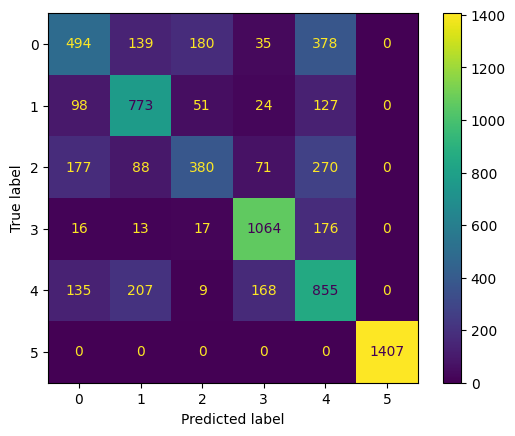

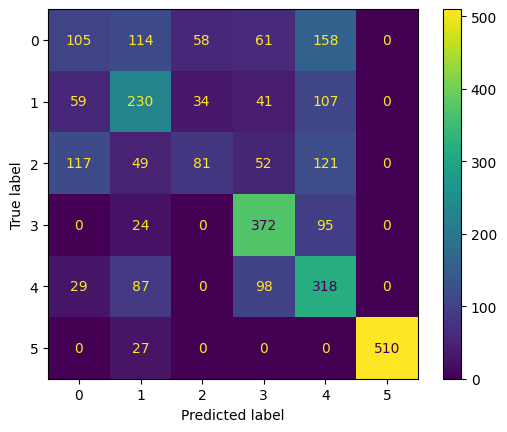

In [77]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV(cv=5)

model.fit(torch.flatten(tsx_train, start_dim=1).cpu().detach().numpy(), y_train_labels)

y_hat = model.predict(torch.flatten(tsx_train, start_dim=1).cpu().detach().numpy())
y_hat_test = model.predict(torch.flatten(tsx_test, start_dim=1).cpu().detach().numpy())

print(f"Train accuracy : {(y_hat == y_train_labels).sum() / len(y_hat)}")
print(f"Test accuracy : {(y_hat_test == y_test_labels).sum() / len(y_hat_test)}")
cm = confusion_matrix(y_train_labels, y_hat)
cm_test = confusion_matrix(y_test_labels, y_hat_test)
ConfusionMatrixDisplay(cm).plot()
ConfusionMatrixDisplay(cm_test).plot()

## Expected path development

In [138]:
def generate_derangement(n):
    while True:
        # Generate a random permutation of elements
        perm = list(range(n))
        random.shuffle(perm)

        # Check if it's a derangement
        if all(perm[i] != i for i in range(n)):
            return perm


def train_model_multichannels(
    model,
    optimizer,
    data_loader,
    hidden_size: int,
    num_epochs=10,
    alpha=0.2,
    beta=0.5,
    verbose=True,
):
    model.train()
    lossx = []
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            X = model(inputs)

            Y0 = X[labels == 0]
            Y1 = X[labels == 1]
            Y2 = X[labels == 2]
            Y3 = X[labels == 3]
            Y4 = X[labels == 4]
            Y5 = X[labels == 5]

            tau_0 = torch.mean(Y0, axis=0) if len(Y0) > 0 else torch.zeros_like(X[0])
            tau_1 = torch.mean(Y1, axis=0) if len(Y1) > 0 else torch.zeros_like(X[0])
            tau_2 = torch.mean(Y2, axis=0) if len(Y2) > 0 else torch.zeros_like(X[0])
            tau_3 = torch.mean(Y3, axis=0) if len(Y3) > 0 else torch.zeros_like(X[0])
            tau_4 = torch.mean(Y4, axis=0) if len(Y4) > 0 else torch.zeros_like(X[0])
            tau_5 = torch.mean(Y5, axis=0) if len(Y5) > 0 else torch.zeros_like(X[0])

            tau = torch.stack([tau_0, tau_1, tau_2, tau_3, tau_4, tau_5])
            dtau = tau - tau[generate_derangement(6)]
            nclass, nchannels, _, _ = dtau.shape
            dtau = dtau.reshape((nclass * nchannels, hidden_size, hidden_size))
            dtau0 = tau_0 - Y0
            dtau1 = tau_1 - Y1
            dtau2 = tau_2 - Y2
            dtau3 = tau_3 - Y3
            dtau4 = tau_4 - Y4
            dtau5 = tau_5 - Y5

            b, c, d, _ = X.shape

            loss = (
                -(1 - beta)
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                / hidden_size
                / b
                - beta
                * (torch.swapaxes(dtau, 1, 2).bmm(dtau).diagonal(dim1=1, dim2=2).sum())
                ** 2
                / hidden_size
                / b
            )
            for dt in [dtau0, dtau1, dtau2, dtau3, dtau4, dtau5]:
                loss += (
                    alpha
                    * torch.norm(
                        torch.swapaxes(dt.reshape((len(dt) * c, d, d)), 1, 2)
                        .bmm(dt.reshape((len(dt) * c, d, d)))
                        .diagonal(dim1=1, dim2=2)
                        .sum(-1)
                    )
                    ** 2
                    / hidden_size
                    / len(dt)
                )
            loss.backward()
            optimizer.step()

            lossx.append(loss.item() / b)

        if verbose:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.sum(lossx[-1000:]) / 1000}"
            )

    return lossx

In [145]:
# build the dataset
batch_size = 128
train = TensorDataset(tsx_train, y_train)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [ ]:
class DevNetMultipleLayers(nn.Module):
    def __init__(self, dev_layer):
        super().__init__(self)
        self.dev_layer = dev_layer
        self.hidden_sizew = dev_layer.hidden_size
        # add an attention layer on the channels before doing the average
        # will allow to select the best samples without having to shift all
        # of them in a coherent direction
        # risk of overfittin
        self.attention = Attention

    def forward(self, x):
        x = self.dev_layer(x)
        x = self.linear(x)
        return x

    def partial_forward(self, x):
        return self.dev_layer(x)

In [151]:
hidden_size = 3
nchannels = 2
dev_layer = development_layer(
    input_size=3,
    hidden_size=hidden_size,
    channels=nchannels,
    param=so,
    complexification=False,
    return_sequence=False,
)

Epoch [1/20], Loss: 1.9914130808891577e-06
Epoch [2/20], Loss: 2.9093213177994974e-06
Epoch [3/20], Loss: 2.62892850501625e-06
Epoch [4/20], Loss: 1.812945971063789e-07
Epoch [5/20], Loss: -5.752734775342105e-06
Epoch [6/20], Loss: -1.7069476370644614e-05
Epoch [7/20], Loss: -3.5138623947854546e-05
Epoch [8/20], Loss: -6.652561336925699e-05
Epoch [9/20], Loss: -0.00012126594146983343
Epoch [10/20], Loss: -0.00022533766760261643
Epoch [11/20], Loss: -0.0004385006864612089
Epoch [12/20], Loss: -0.000857630077828357
Epoch [13/20], Loss: -0.0015585841528995197
Epoch [14/20], Loss: -0.002602933593139954
Epoch [15/20], Loss: -0.0036237144429426605
Epoch [16/20], Loss: -0.004635587286648843
Epoch [17/20], Loss: -0.005704555690250995
Epoch [18/20], Loss: -0.006785537233218878
Epoch [19/20], Loss: -0.007867935281221176
Epoch [20/20], Loss: -0.008844925411945951


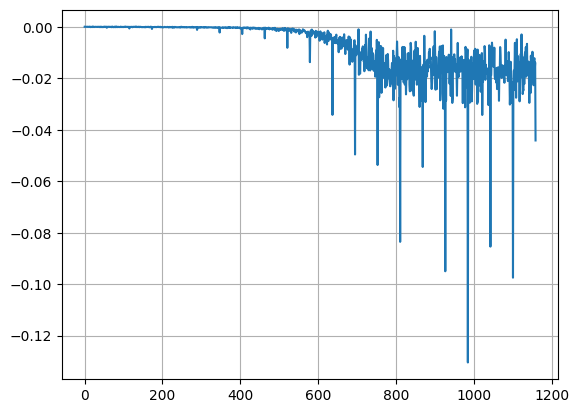

In [152]:
# optimizer = optim.Adam(dev_layer.parameters(), lr=0.002)
optimizer = optim.SGD(dev_layer.parameters(), lr=0.0001, momentum=0.99)

lossx = train_model_multichannels(
    dev_layer, optimizer, train_loader, hidden_size, num_epochs=20, alpha=0.08, beta=0.6
)
_, ax = plt.subplots()
ax.plot(range(len(lossx)), lossx)
ax.grid()

In [153]:
dev_layer.eval()

dev_train = dev_layer(tsx_train)
dt0 = dev_train[y_train == 0]
dt1 = dev_train[y_train == 1]
dt2 = dev_train[y_train == 2]
dt3 = dev_train[y_train == 3]
dt4 = dev_train[y_train == 4]
dt5 = dev_train[y_train == 5]
tau0 = torch.mean(dt0, axis=0)
tau1 = torch.mean(dt1, axis=0)
tau2 = torch.mean(dt2, axis=0)
tau3 = torch.mean(dt3, axis=0)
tau4 = torch.mean(dt4, axis=0)
tau5 = torch.mean(dt5, axis=0)

diff0 = (dev_train - tau0).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff1 = (dev_train - tau1).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff2 = (dev_train - tau2).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff3 = (dev_train - tau3).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff4 = (dev_train - tau4).reshape((len(y_train) * nchannels, hidden_size, hidden_size))
diff5 = (dev_train - tau5).reshape((len(y_train) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_train), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c = dd.argmin(dim=0)
print("train accuracy : ", (y_train == c).sum().numpy() / len(y_train))

dev_test = dev_layer(tsx_test)

diff0 = (dev_test - tau0).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff1 = (dev_test - tau1).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff2 = (dev_test - tau2).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff3 = (dev_test - tau3).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff4 = (dev_test - tau4).reshape((len(y_test) * nchannels, hidden_size, hidden_size))
diff5 = (dev_test - tau5).reshape((len(y_test) * nchannels, hidden_size, hidden_size))

dd0 = (
    torch.swapaxes(diff0, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd1 = (
    torch.swapaxes(diff1, 1, 2)
    .bmm(diff1)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd2 = (
    torch.swapaxes(diff2, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd3 = (
    torch.swapaxes(diff3, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd4 = (
    torch.swapaxes(diff4, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)
dd5 = (
    torch.swapaxes(diff5, 1, 2)
    .bmm(diff2)
    .reshape((len(y_test), nchannels, hidden_size, hidden_size))
    .diagonal(dim1=2, dim2=3)
    .sum(-1)
    .sum(-1)
)

dd_test = torch.stack([dd0, dd1, dd2, dd3, dd4, dd5])
c_test = dd_test.argmin(dim=0)
print("test accuracy : ", (y_test.numpy() == c_test.numpy()).sum() / len(y_test))

train accuracy :  0.6067736670293797
test accuracy :  0.5955208686800135


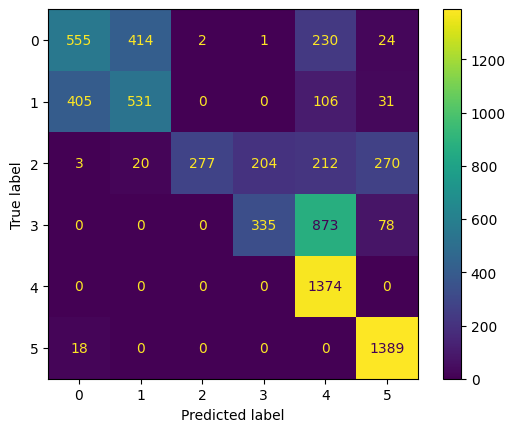

In [154]:
cm = confusion_matrix(y_train, c)
ConfusionMatrixDisplay(cm).plot()

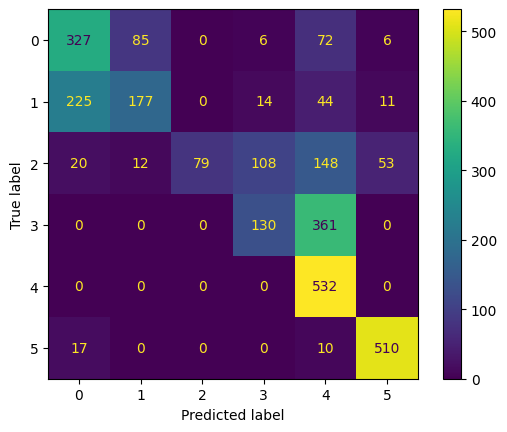

In [155]:
cm_test = confusion_matrix(y_test, c_test)
ConfusionMatrixDisplay(cm_test).plot()

## Multi-Head path development model

In [7]:
from models.attention_development import (
    MultiheadAttentionDevelopment,
    GroupConfig,
    AttentionDevelopmentConfig,
)

from development.so import so
from development.he import he
from development.gl import gl

In [43]:
multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=so, dim=4, channels=3),
        GroupConfig(group=so, dim=4, channels=3),
    ],
)

model = MultiheadAttentionDevelopment(
    dropout=0.1, input_dim=3, hidden_dim=6, multidev_config=multidev_config
).to(device)

x = torch.randn((10, 100, 3)).to(device)
out = model(x)
len(out), out[0].shape, out[1].shape

(2, torch.Size([10, 3, 4, 4]), torch.Size([10, 3, 4, 4]))

In [9]:
# tsx_train = torch.Tensor(tsx_train.swapaxes(1, 2))
batch_size = 1000
s1, s2 = model(tsx_train[:batch_size])
s1.shape, s2.shape

(torch.Size([1000, 3, 4, 4]), torch.Size([1000, 3, 4, 4]))

In [10]:
n_class = 6

l1 = nn.Linear(3 * 4 * 4, n_class)
l2 = nn.Linear(3 * 4 * 4, n_class)

x1 = l1(s1.view(len(s1), -1))
x2 = l2(s2.view(len(s2), -1))
y = x1 + x2
y

tensor([[-0.0774,  0.1029, -0.3782, -0.3388,  0.3012, -0.4417],
        [-0.0748,  0.1038, -0.3782, -0.3387,  0.3019, -0.4425],
        [-0.0722,  0.1020, -0.3793, -0.3369,  0.3022, -0.4423],
        ...,
        [-0.0706,  0.1008, -0.3785, -0.3366,  0.3010, -0.4420],
        [-0.0736,  0.1027, -0.3782, -0.3381,  0.3013, -0.4423],
        [-0.0745,  0.1028, -0.3789, -0.3378,  0.3022, -0.4422]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [44]:
class FullModel(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        in_dim1 = (
            multidev_config.groups[0].channels * multidev_config.groups[0].dim ** 2
        )
        in_dim2 = (
            multidev_config.groups[0].channels * multidev_config.groups[1].dim ** 2
        )
        self.l1 = nn.Linear(in_dim1, out_dim)
        self.l2 = nn.Linear(in_dim2, out_dim)

    def forward_partial(self, x: Tensor):
        s1, s2 = self.atdev(x)
        return s1, s2

    def forward(self, x: Tensor):
        s1, s2 = self.atdev(x)
        y1 = self.l1(s1.view(len(s1), -1))
        y2 = self.l2(s2.view(len(s2), -1))
        return y1 + y2

In [45]:
n_class = 6
batch_size = 128
fm = FullModel(
    dropout=0.05,
    input_dim=3,
    hidden_dim=6,
    out_dim=n_class,
    multidev_config=multidev_config,
).to(device)

z = fm(tsx_train[:batch_size])
z

tensor([[ 0.2266,  0.6085,  0.4451,  0.1082,  0.5337, -0.4675],
        [ 0.2263,  0.6091,  0.4458,  0.1085,  0.5330, -0.4690],
        [ 0.2263,  0.6082,  0.4454,  0.1079,  0.5333, -0.4684],
        [ 0.2259,  0.6087,  0.4462,  0.1092,  0.5328, -0.4691],
        [ 0.2264,  0.6074,  0.4451,  0.1066,  0.5341, -0.4668],
        [ 0.2263,  0.6089,  0.4457,  0.1086,  0.5331, -0.4687],
        [ 0.2262,  0.6083,  0.4457,  0.1076,  0.5335, -0.4679],
        [ 0.2269,  0.6077,  0.4443,  0.1074,  0.5339, -0.4674],
        [ 0.2261,  0.6082,  0.4457,  0.1083,  0.5333, -0.4682],
        [ 0.2262,  0.6085,  0.4457,  0.1084,  0.5333, -0.4682],
        [ 0.2268,  0.6077,  0.4446,  0.1061,  0.5339, -0.4674],
        [ 0.2255,  0.6105,  0.4475,  0.1104,  0.5321, -0.4703],
        [ 0.2261,  0.6087,  0.4460,  0.1080,  0.5332, -0.4683],
        [ 0.2273,  0.6077,  0.4439,  0.1049,  0.5345, -0.4666],
        [ 0.2256,  0.6106,  0.4475,  0.1111,  0.5322, -0.4699],
        [ 0.2265,  0.6080,  0.4452,  0.1

In [13]:
loss = z - y_train[:batch_size]

In [14]:
tsx_train.shape, y_train.shape

(torch.Size([7352, 206, 3]), torch.Size([7352, 6]))

In [46]:
# Define batch size
batch_size = 256

# Create DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(tsx_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)
test_dataset = torch.utils.data.TensorDataset(tsx_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)

print(f"Number of batches: {len(train_loader)}")

Number of batches: 29


In [88]:
nepochs = 50
learning_rate = 1e-3


def train_model(fm: nn.Module, nepochs: int, learning_rate: float):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx = []
    for epoch in tqdm(range(nepochs)):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

    return fm, lossx


def train_model_with_test_error(fm: nn.Module, nepochs: int, learning_rate: float):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx, lossx_test = [], []
    for epoch in tqdm(range(nepochs)):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()
        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

        if epoch % 4 != 0:
            continue
        # compute the test error
        for x, y in test_loader:
            optimizer.zero_grad()
            y_hat = fm(x)
            loss = torch.sum((y - y_hat) ** 2) / len(y)
            loss.backward()
            lossx_test.append(loss.item())
            optimizer.step()
    return fm, lossx, lossx_test


# fm, lossx = train_model(fm, nepochs, learning_rate)

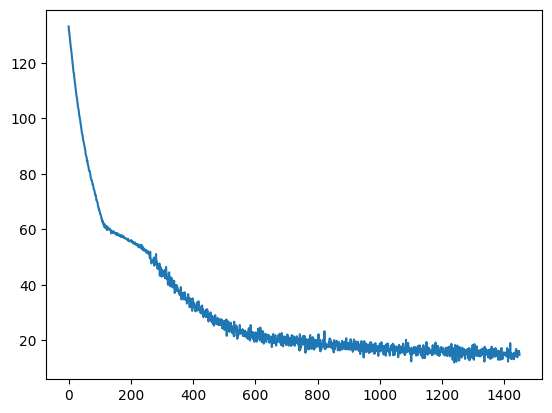

In [20]:
ax = plt.plot(range(len(lossx)), lossx)

In [21]:
def train_sample_accuracy(fm: nn.Module):
    fm.eval()
    n_true_prediction = 0
    preds, trues = [], []
    for x, y in train_loader:
        y_hat = fm(x)
        y_pred = torch.argmax(y_hat, axis=1)
        y_true = torch.argmax(y, axis=1)
        n_true_prediction += torch.sum(y_pred == y_true).detach().cpu().numpy()
        preds = np.concatenate([preds, y_pred.detach().cpu().numpy()])
        trues = np.concatenate([trues, y_true.detach().cpu().numpy()])
    cm = confusion_matrix(trues, preds)
    ConfusionMatrixDisplay(cm).plot()
    return n_true_prediction / len(y_train)


def test_sample_accuracy(fm: nn.Module):
    fm.eval()
    n_true_prediction = 0
    preds, trues = [], []
    for x, y in test_loader:
        y_hat = fm(x)
        y_pred = torch.argmax(y_hat, axis=1)
        y_true = torch.argmax(y, axis=1)
        n_true_prediction += torch.sum(y_pred == y_true).detach().cpu().numpy()
        preds = np.concatenate([preds, y_pred.detach().cpu().numpy()])
        trues = np.concatenate([trues, y_true.detach().cpu().numpy()])

    cm = confusion_matrix(trues, preds)
    ConfusionMatrixDisplay(cm).plot()
    return n_true_prediction / len(y_test)

0.8866974972796517

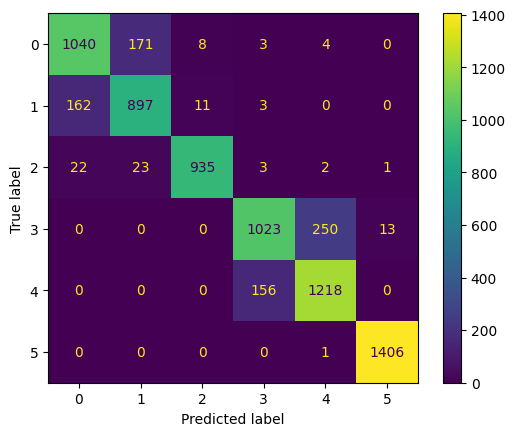

In [22]:
train_acc = train_sample_accuracy(fm)
train_acc

0.831353919239905

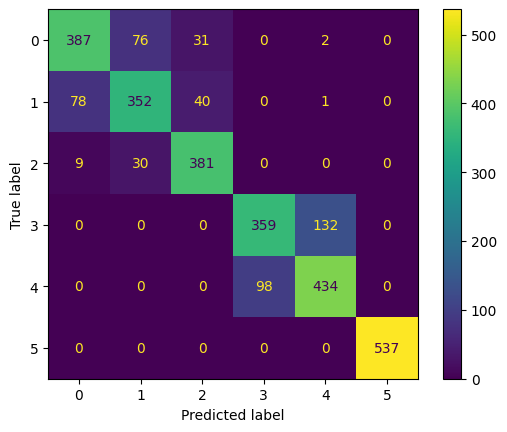

In [23]:
test_sample_accuracy(fm)

### GL

In [21]:
class FullModel(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        in_dim1 = (
            multidev_config.groups[0].channels * multidev_config.groups[0].dim ** 2
        )
        in_dim2 = (
            multidev_config.groups[0].channels * multidev_config.groups[1].dim ** 2
        )
        self.l1 = nn.Linear(in_dim1, out_dim)
        self.l2 = nn.Linear(in_dim2, out_dim)

    def forward_partial(self, x: Tensor):
        s1, s2 = self.atdev(x)
        return s1, s2

    def forward(self, x: Tensor):
        s1, s2 = self.atdev(x)
        y1 = self.l1(s1.view(len(s1), -1))
        y2 = self.l2(s2.view(len(s2), -1))
        return y1 + y2

In [22]:
multidev_config = AttentionDevelopmentConfig(
    n_heads=2,
    groups=[
        GroupConfig(group=gl, dim=3, channels=3),
        GroupConfig(group=gl, dim=4, channels=3),
    ],
)
fm = FullModel(
    dropout=0.05,
    input_dim=3,
    hidden_dim=6,
    out_dim=n_class,
    multidev_config=multidev_config,
)


def train_model_l2(nepochs: int, learning_rate: float, fm: nn.Module, alpha: float):
    fm.train()
    optimizer = optim.Adam(fm.parameters(), lr=learning_rate)
    lossx = []
    for epoch in range(nepochs):
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_hat = fm(x)
            s1, s2 = fm.forward_partial(x)
            loss = (
                torch.sum((y - y_hat) ** 2) / len(y)
                + alpha * torch.linalg.norm(s1)
                + alpha * torch.linalg.norm(s2)
            )  # norm parameters
            loss.backward()
            lossx.append(loss.item())
            optimizer.step()

        print(f"Epoch : {epoch} | Loss {lossx[-1]} | gradient {0.}")

    return fm, lossx


nepochs = 15
learning_rate = 1e-3
alpha = 1e-2
fm, lossx = train_model_l2(nepochs, learning_rate, fm, alpha)

100%|██████████| 58/58 [01:01<00:00,  1.07s/it]


Epoch : 0 | Loss 98.23477935791016 | gradient 0.0


100%|██████████| 58/58 [00:52<00:00,  1.10it/s]


Epoch : 1 | Loss 63.7432975769043 | gradient 0.0


100%|██████████| 58/58 [01:02<00:00,  1.07s/it]


Epoch : 2 | Loss 59.70664596557617 | gradient 0.0


100%|██████████| 58/58 [01:16<00:00,  1.31s/it]


Epoch : 3 | Loss 57.61484909057617 | gradient 0.0


100%|██████████| 58/58 [01:15<00:00,  1.30s/it]


Epoch : 4 | Loss 54.857627868652344 | gradient 0.0


100%|██████████| 58/58 [01:13<00:00,  1.26s/it]


Epoch : 5 | Loss 52.60029220581055 | gradient 0.0


100%|██████████| 58/58 [01:14<00:00,  1.28s/it]


Epoch : 6 | Loss 49.89402770996094 | gradient 0.0


100%|██████████| 58/58 [01:10<00:00,  1.22s/it]


Epoch : 7 | Loss 47.07049560546875 | gradient 0.0


100%|██████████| 58/58 [01:09<00:00,  1.19s/it]


Epoch : 8 | Loss 51.951629638671875 | gradient 0.0


100%|██████████| 58/58 [01:08<00:00,  1.19s/it]


Epoch : 9 | Loss 47.643775939941406 | gradient 0.0


100%|██████████| 58/58 [01:15<00:00,  1.31s/it]


Epoch : 10 | Loss 45.149757385253906 | gradient 0.0


100%|██████████| 58/58 [01:10<00:00,  1.21s/it]


Epoch : 11 | Loss 45.03959655761719 | gradient 0.0


100%|██████████| 58/58 [01:10<00:00,  1.21s/it]


Epoch : 12 | Loss 39.061038970947266 | gradient 0.0


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]


Epoch : 13 | Loss 41.5740852355957 | gradient 0.0


100%|██████████| 58/58 [00:58<00:00,  1.02s/it]

Epoch : 14 | Loss 36.206459045410156 | gradient 0.0


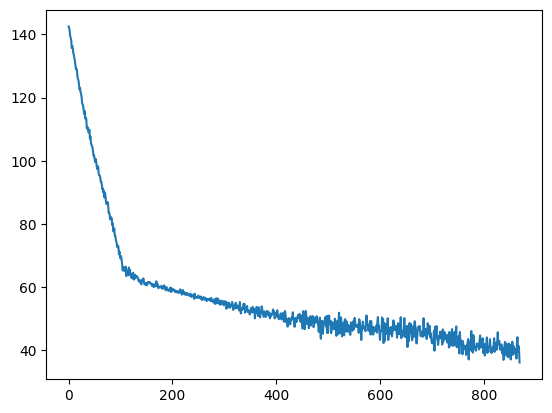

In [23]:
plt.plot(range(len(lossx)), lossx)

0.5405331882480957

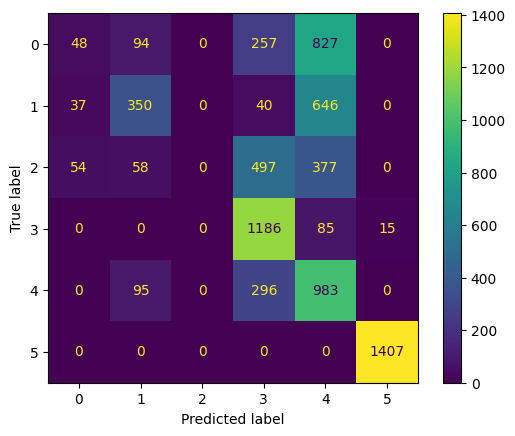

In [24]:
train_sample_accuracy(fm)

In [25]:
fm

FullModel(
  (atdev): MultiheadAttentionDevelopment(
    (q): Linear(in_features=3, out_features=6, bias=True)
    (k): Linear(in_features=3, out_features=6, bias=True)
    (v): Linear(in_features=3, out_features=6, bias=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (development_layers): ModuleList(
      (0-1): 2 x development_layer(
        (projection): projection(
          (param_map): gl()
        )
      )
    )
  )
  (l1): Linear(in_features=27, out_features=6, bias=True)
  (l2): Linear(in_features=48, out_features=6, bias=True)
)

In [28]:
s1, s2 = fm.forward_partial(tsx_train[:10])

In [36]:
torch.linalg.norm(s1, axis=[2, 3])

tensor([[2.3075, 2.1119, 2.0856],
        [1.5792, 0.8349, 1.9122],
        [1.7043, 0.8424, 1.6550],
        [1.6541, 0.7769, 1.6946],
        [1.6260, 0.7427, 1.9050],
        [1.8325, 0.8877, 1.6857],
        [1.8053, 0.9655, 1.5673],
        [1.6929, 0.8205, 1.6119],
        [1.6214, 0.8179, 1.6748],
        [1.6490, 0.8307, 1.6063]], grad_fn=<LinalgVectorNormBackward0>)

In [37]:
s1

tensor([[[[ 1.1649e+00,  3.3419e-01,  3.2915e-01],
          [-8.2201e-02,  1.0932e+00,  9.1905e-02],
          [ 4.5589e-01, -3.3054e-01,  1.4899e+00]],

         [[ 1.1175e+00,  8.9530e-02, -1.2087e-02],
          [ 3.5268e-02,  1.2200e+00,  2.9413e-01],
          [ 3.0807e-02, -3.5693e-01,  1.2243e+00]],

         [[ 9.8456e-01,  3.1199e-02, -2.0077e-01],
          [-2.2756e-03,  1.3153e+00, -1.3468e-01],
          [-3.8882e-01, -4.2374e-01,  1.1226e+00]]],


        [[[ 3.9992e-01, -6.2292e-01, -5.6254e-01],
          [ 3.3531e-01,  1.0058e+00,  2.8405e-01],
          [-2.6586e-01,  2.9318e-01,  5.1757e-01]],

         [[ 6.7078e-01, -2.5479e-01, -2.8257e-02],
          [ 4.2206e-03, -8.0830e-02, -3.2070e-01],
          [-5.2256e-02,  2.5226e-01, -7.5150e-02]],

         [[ 9.7290e-01, -3.9607e-01,  4.4431e-01],
          [ 5.0685e-01,  4.3590e-01,  6.1681e-01],
          [ 3.9655e-01,  3.4455e-01,  1.1192e+00]]],


        [[[ 3.4716e-01, -2.4923e-01, -4.7944e-01],
          [ 4.1

In [55]:
torch.save(fm.state_dict(), "fm_model")

In [58]:
fm = FullModel(
    dropout=0.05,
    input_dim=3,
    hidden_dim=6,
    out_dim=n_class,
    multidev_config=multidev_config,
)
fm.load_state_dict(torch.load("fm_model", weights_only=True))
fm.eval()

FullModel(
  (atdev): MultiheadAttentionDevelopment(
    (q): Linear(in_features=3, out_features=6, bias=True)
    (k): Linear(in_features=3, out_features=6, bias=True)
    (v): Linear(in_features=3, out_features=6, bias=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (development_layers): ModuleList(
      (0-1): 2 x development_layer(
        (projection): projection(
          (param_map): gl()
        )
      )
    )
  )
  (l1): Linear(in_features=27, out_features=6, bias=True)
  (l2): Linear(in_features=48, out_features=6, bias=True)
)

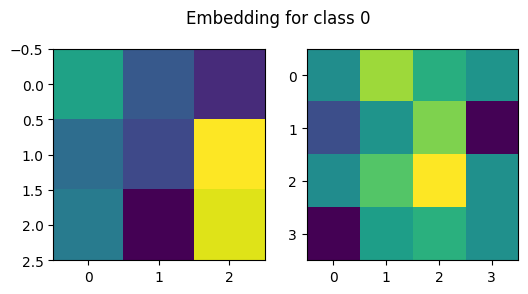

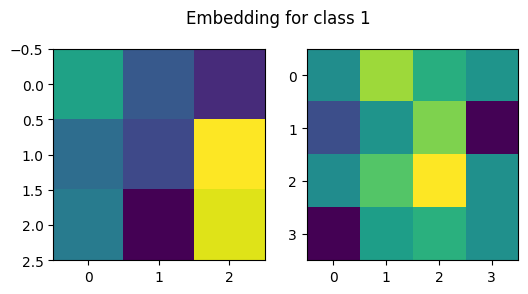

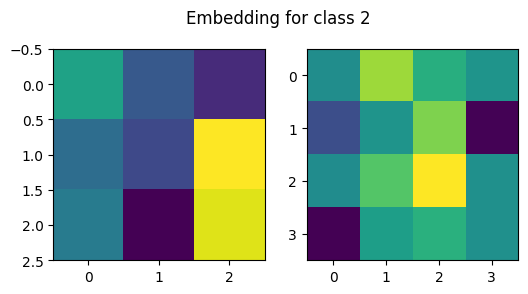

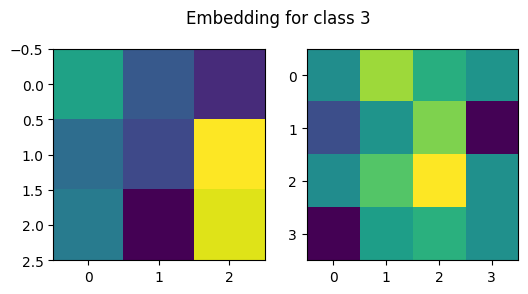

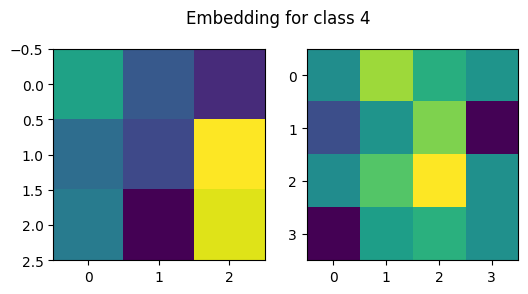

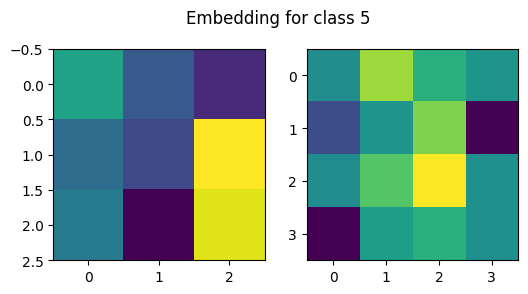

In [73]:
label_class = 0
tsx_train_class = tsx_train[y_train_labels.astype(float).astype(int) == label_class]
n_samples = 100
for label_class in range(6):
    s1, s2 = fm.forward_partial(tsx_train_class[:n_samples])
    fig, axs = plt.subplots(ncols=2, figsize=(6, 3))
    axs[0].imshow(torch.mean(s1, axis=0).detach().numpy()[0, :, :])
    axs[1].imshow(torch.mean(s2, axis=0).detach().numpy()[0, :, :])
    fig.suptitle(f"Embedding for class {label_class}")

In [60]:
tsx_train_class

tensor([], size=(0, 206, 3))

In [64]:
(y_train_labels == label_class).sum()

1226

# Alternative models

## Bagging

In [104]:
class PDevBaggingClaffifier(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim // 2)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        sx = self.atdev(x)
        return sx

    def forward(self, x: Tensor):
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

In [99]:
n_class = 6
multidev_config = AttentionDevelopmentConfig(
    n_heads=4,
    groups=[
        GroupConfig(group=so, dim=3, channels=3),
        GroupConfig(group=so, dim=4, channels=3),
        # GroupConfig(group=so, dim=5, channels=3),
    ],
)

fm = PDevBaggingClaffifier(
    dropout=0.05,
    input_dim=3,
    hidden_dim=12,
    out_dim=n_class,
    multidev_config=multidev_config,
)

# ? number of parameters

params = list(fm.parameters())
n_params = np.sum([np.prod(t.shape) for t in params])
n_params

In [100]:
nepochs = 40
learning_rate = 5e-4

# fm, lossx = train_model(fm, nepochs, learning_rate)
fm, lossx, lossx_test = train_model_with_test_error(fm, nepochs, learning_rate)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 0 | Loss 115.57801818847656 | gradient 0.0


  5%|▌         | 2/40 [00:28<08:44, 13.80s/it]

Epoch : 1 | Loss 79.6365737915039 | gradient 0.0


  8%|▊         | 3/40 [00:40<07:53, 12.80s/it]

Epoch : 2 | Loss 61.90923309326172 | gradient 0.0


 10%|█         | 4/40 [00:51<07:24, 12.35s/it]

Epoch : 3 | Loss 59.26483917236328 | gradient 0.0
Epoch : 4 | Loss 58.74149703979492 | gradient 0.0


 15%|█▌        | 6/40 [01:19<07:22, 13.02s/it]

Epoch : 5 | Loss 58.178977966308594 | gradient 0.0


 18%|█▊        | 7/40 [01:31<06:54, 12.57s/it]

Epoch : 6 | Loss 57.70795440673828 | gradient 0.0


 20%|██        | 8/40 [01:42<06:33, 12.29s/it]

Epoch : 7 | Loss 55.8517951965332 | gradient 0.0
Epoch : 8 | Loss 52.59726333618164 | gradient 0.0


 25%|██▌       | 10/40 [02:11<06:30, 13.03s/it]

Epoch : 9 | Loss 49.97112274169922 | gradient 0.0


 28%|██▊       | 11/40 [02:22<06:07, 12.69s/it]

Epoch : 10 | Loss 45.74951934814453 | gradient 0.0


 30%|███       | 12/40 [02:34<05:48, 12.44s/it]

Epoch : 11 | Loss 39.64409255981445 | gradient 0.0
Epoch : 12 | Loss 36.62061309814453 | gradient 0.0


 35%|███▌      | 14/40 [03:03<05:44, 13.24s/it]

Epoch : 13 | Loss 33.46167755126953 | gradient 0.0


 38%|███▊      | 15/40 [03:15<05:23, 12.93s/it]

Epoch : 14 | Loss 33.324642181396484 | gradient 0.0


 40%|████      | 16/40 [03:28<05:05, 12.74s/it]

Epoch : 15 | Loss 29.111190795898438 | gradient 0.0
Epoch : 16 | Loss 30.73876190185547 | gradient 0.0


 45%|████▌     | 18/40 [03:57<04:56, 13.50s/it]

Epoch : 17 | Loss 29.82737159729004 | gradient 0.0


 48%|████▊     | 19/40 [04:09<04:33, 13.04s/it]

Epoch : 18 | Loss 29.648374557495117 | gradient 0.0


 50%|█████     | 20/40 [04:22<04:18, 12.93s/it]

Epoch : 19 | Loss 25.463300704956055 | gradient 0.0
Epoch : 20 | Loss 27.7814884185791 | gradient 0.0


 55%|█████▌    | 22/40 [04:51<04:05, 13.63s/it]

Epoch : 21 | Loss 24.482847213745117 | gradient 0.0


 57%|█████▊    | 23/40 [05:04<03:49, 13.48s/it]

Epoch : 22 | Loss 24.9642276763916 | gradient 0.0


 60%|██████    | 24/40 [05:17<03:32, 13.31s/it]

Epoch : 23 | Loss 26.86166763305664 | gradient 0.0
Epoch : 24 | Loss 24.44916343688965 | gradient 0.0


 65%|██████▌   | 26/40 [05:47<03:16, 14.02s/it]

Epoch : 25 | Loss 22.31000328063965 | gradient 0.0


 68%|██████▊   | 27/40 [06:00<02:56, 13.55s/it]

Epoch : 26 | Loss 24.735612869262695 | gradient 0.0


 70%|███████   | 28/40 [06:12<02:38, 13.25s/it]

Epoch : 27 | Loss 24.01323127746582 | gradient 0.0
Epoch : 28 | Loss 22.379358291625977 | gradient 0.0


 75%|███████▌  | 30/40 [06:42<02:18, 13.82s/it]

Epoch : 29 | Loss 22.04207420349121 | gradient 0.0


 78%|███████▊  | 31/40 [06:54<01:59, 13.33s/it]

Epoch : 30 | Loss 22.512042999267578 | gradient 0.0


 80%|████████  | 32/40 [07:06<01:43, 12.97s/it]

Epoch : 31 | Loss 23.324888229370117 | gradient 0.0
Epoch : 32 | Loss 22.476186752319336 | gradient 0.0


 85%|████████▌ | 34/40 [07:35<01:21, 13.59s/it]

Epoch : 33 | Loss 20.361326217651367 | gradient 0.0


 88%|████████▊ | 35/40 [07:48<01:05, 13.16s/it]

Epoch : 34 | Loss 24.663835525512695 | gradient 0.0


 90%|█████████ | 36/40 [08:00<00:51, 12.87s/it]

Epoch : 35 | Loss 19.907756805419922 | gradient 0.0
Epoch : 36 | Loss 19.137279510498047 | gradient 0.0


 95%|█████████▌| 38/40 [08:29<00:27, 13.55s/it]

Epoch : 37 | Loss 18.08833885192871 | gradient 0.0


 98%|█████████▊| 39/40 [08:42<00:13, 13.36s/it]

Epoch : 38 | Loss 18.363140106201172 | gradient 0.0


100%|██████████| 40/40 [08:56<00:00, 13.40s/it]

Epoch : 39 | Loss 18.551992416381836 | gradient 0.0


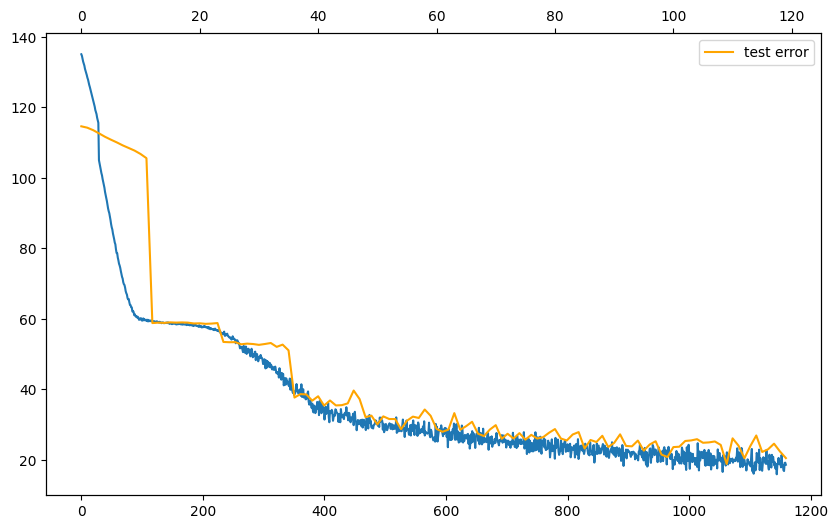

In [101]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.8044069640914037

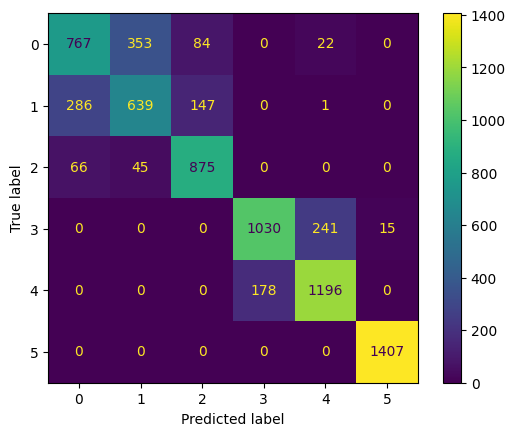

In [102]:
train_acc = train_sample_accuracy(fm)
train_acc

0.7706141839158466

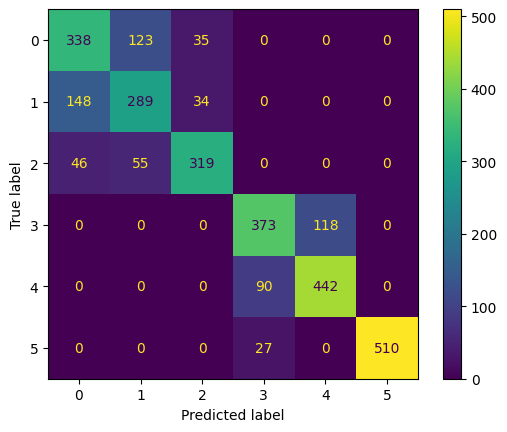

In [103]:
test_sample_accuracy(fm)

## Bi LSTM feature extraction

In [153]:
class PDevBaggingBiLSTM(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        head_sizes = [g.channels * g.dim**2 for g in multidev_config.groups]
        inter_dim = sum(head_sizes)
        self.lin1 = nn.Linear(inter_dim, inter_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(inter_dim, out_dim)

    def forward_partial(self, x: Tensor):
        x, _ = self.lstm(x)
        sx = self.atdev(x)
        return sx

    def forward(self, x: Tensor):
        # print(x.shape)
        x, _ = self.lstm(x)
        # print(x.shape)
        sx = self.atdev(x)
        sx_flat = [s.view(len(s), -1) for s in sx]
        sc = torch.cat(sx_flat, axis=-1)
        y = self.lin1(sc)
        y = self.relu(y)
        y = self.lin2(y)
        return y

In [159]:
n_class = 6
multidev_config = AttentionDevelopmentConfig(
    n_heads=3,
    groups=[
        GroupConfig(group=so, dim=3, channels=2),
        GroupConfig(group=so, dim=3, channels=2),
        GroupConfig(group=so, dim=3, channels=2),
    ],
)

fm = PDevBaggingBiLSTM(
    dropout=0.05,
    input_dim=3,
    hidden_dim=9,
    out_dim=n_class,
    multidev_config=multidev_config,
)

# ? number of parameters

params = list(fm.parameters())
n_params = np.sum([np.prod(t.shape) for t in params])
n_params

4596

In [160]:
nepochs = 50
learning_rate = 5e-4

# fm, lossx = train_model(fm, nepochs, learning_rate)
fm, lossx, lossx_test = train_model_with_test_error(fm, nepochs, learning_rate)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 0 | Loss 126.5357437133789 | gradient 0.0


  4%|▍         | 2/50 [00:20<08:00, 10.01s/it]

Epoch : 1 | Loss 103.91242980957031 | gradient 0.0


  6%|▌         | 3/50 [00:29<07:21,  9.40s/it]

Epoch : 2 | Loss 84.38603973388672 | gradient 0.0


  8%|▊         | 4/50 [00:38<07:00,  9.13s/it]

Epoch : 3 | Loss 65.39717864990234 | gradient 0.0
Epoch : 4 | Loss 59.161865234375 | gradient 0.0


 12%|█▏        | 6/50 [00:58<06:59,  9.54s/it]

Epoch : 5 | Loss 55.71283721923828 | gradient 0.0


 14%|█▍        | 7/50 [01:06<06:32,  9.12s/it]

Epoch : 6 | Loss 52.76316452026367 | gradient 0.0


 16%|█▌        | 8/50 [01:14<06:11,  8.85s/it]

Epoch : 7 | Loss 49.669212341308594 | gradient 0.0
Epoch : 8 | Loss 48.2335205078125 | gradient 0.0


 20%|██        | 10/50 [01:34<06:10,  9.27s/it]

Epoch : 9 | Loss 47.53477478027344 | gradient 0.0


 22%|██▏       | 11/50 [01:43<05:49,  8.96s/it]

Epoch : 10 | Loss 46.13837432861328 | gradient 0.0


 24%|██▍       | 12/50 [01:51<05:33,  8.77s/it]

Epoch : 11 | Loss 46.64214324951172 | gradient 0.0
Epoch : 12 | Loss 44.21940994262695 | gradient 0.0


 28%|██▊       | 14/50 [02:11<05:32,  9.24s/it]

Epoch : 13 | Loss 43.05393981933594 | gradient 0.0


 30%|███       | 15/50 [02:19<05:14,  8.98s/it]

Epoch : 14 | Loss 39.265838623046875 | gradient 0.0


 32%|███▏      | 16/50 [02:28<04:59,  8.80s/it]

Epoch : 15 | Loss 37.473655700683594 | gradient 0.0
Epoch : 16 | Loss 34.54846954345703 | gradient 0.0


 36%|███▌      | 18/50 [02:48<04:57,  9.30s/it]

Epoch : 17 | Loss 28.952091217041016 | gradient 0.0


 38%|███▊      | 19/50 [02:56<04:39,  9.02s/it]

Epoch : 18 | Loss 24.8990478515625 | gradient 0.0


 40%|████      | 20/50 [03:06<04:33,  9.11s/it]

Epoch : 19 | Loss 25.537025451660156 | gradient 0.0
Epoch : 20 | Loss 20.82269859313965 | gradient 0.0


 44%|████▍     | 22/50 [03:26<04:27,  9.54s/it]

Epoch : 21 | Loss 17.350793838500977 | gradient 0.0


 46%|████▌     | 23/50 [03:34<04:08,  9.20s/it]

Epoch : 22 | Loss 19.982114791870117 | gradient 0.0


 48%|████▊     | 24/50 [03:43<03:52,  8.96s/it]

Epoch : 23 | Loss 15.86550235748291 | gradient 0.0
Epoch : 24 | Loss 12.05210018157959 | gradient 0.0


 52%|█████▏    | 26/50 [04:03<03:45,  9.42s/it]

Epoch : 25 | Loss 13.588489532470703 | gradient 0.0


 54%|█████▍    | 27/50 [04:12<03:31,  9.21s/it]

Epoch : 26 | Loss 14.335124015808105 | gradient 0.0


 56%|█████▌    | 28/50 [04:20<03:18,  9.01s/it]

Epoch : 27 | Loss 12.85057258605957 | gradient 0.0
Epoch : 28 | Loss 13.42682933807373 | gradient 0.0


 60%|██████    | 30/50 [04:41<03:09,  9.45s/it]

Epoch : 29 | Loss 12.248754501342773 | gradient 0.0


 62%|██████▏   | 31/50 [04:49<02:54,  9.16s/it]

Epoch : 30 | Loss 10.508753776550293 | gradient 0.0


 64%|██████▍   | 32/50 [04:58<02:41,  8.95s/it]

Epoch : 31 | Loss 11.05421257019043 | gradient 0.0
Epoch : 32 | Loss 12.204094886779785 | gradient 0.0


 68%|██████▊   | 34/50 [05:18<02:30,  9.42s/it]

Epoch : 33 | Loss 9.74703311920166 | gradient 0.0


 70%|███████   | 35/50 [05:27<02:17,  9.14s/it]

Epoch : 34 | Loss 11.54261589050293 | gradient 0.0


 72%|███████▏  | 36/50 [05:35<02:05,  8.95s/it]

Epoch : 35 | Loss 11.352312088012695 | gradient 0.0
Epoch : 36 | Loss 8.46873950958252 | gradient 0.0


 76%|███████▌  | 38/50 [05:55<01:53,  9.43s/it]

Epoch : 37 | Loss 8.470671653747559 | gradient 0.0


 78%|███████▊  | 39/50 [06:04<01:40,  9.15s/it]

Epoch : 38 | Loss 6.80873966217041 | gradient 0.0


 80%|████████  | 40/50 [06:12<01:29,  8.95s/it]

Epoch : 39 | Loss 10.954304695129395 | gradient 0.0
Epoch : 40 | Loss 8.061248779296875 | gradient 0.0


 84%|████████▍ | 42/50 [06:33<01:15,  9.43s/it]

Epoch : 41 | Loss 8.799489974975586 | gradient 0.0


 86%|████████▌ | 43/50 [06:41<01:04,  9.15s/it]

Epoch : 42 | Loss 12.982967376708984 | gradient 0.0


 88%|████████▊ | 44/50 [06:50<00:53,  8.99s/it]

Epoch : 43 | Loss 10.82100772857666 | gradient 0.0
Epoch : 44 | Loss 9.25979995727539 | gradient 0.0


 92%|█████████▏| 46/50 [07:10<00:37,  9.47s/it]

Epoch : 45 | Loss 8.637832641601562 | gradient 0.0


 94%|█████████▍| 47/50 [07:19<00:27,  9.17s/it]

Epoch : 46 | Loss 7.774877071380615 | gradient 0.0


 96%|█████████▌| 48/50 [07:27<00:17,  8.97s/it]

Epoch : 47 | Loss 9.813643455505371 | gradient 0.0
Epoch : 48 | Loss 8.439107894897461 | gradient 0.0


100%|██████████| 50/50 [07:48<00:00,  9.37s/it]

Epoch : 49 | Loss 8.947142601013184 | gradient 0.0


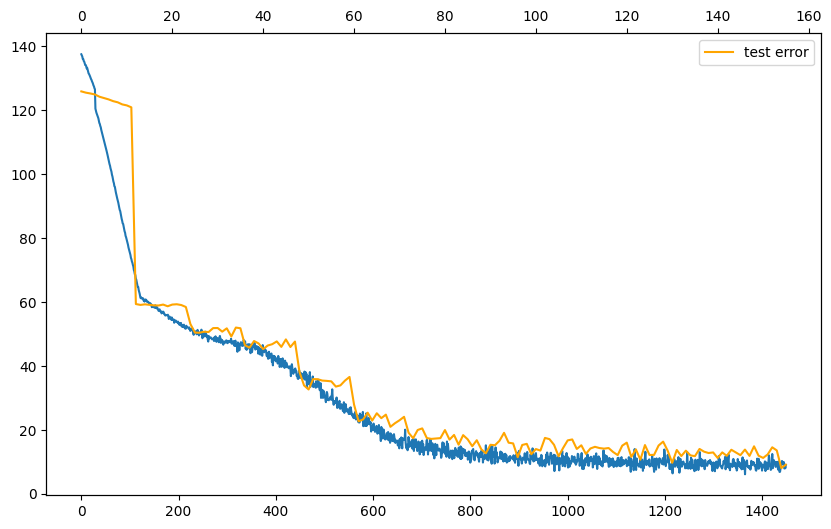

In [161]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(lossx)), lossx)
ax_twin = ax.twiny()
ax_twin.plot(range(len(lossx_test)), lossx_test, color="orange", label="test error")
ax_twin.legend()

0.9220620239390642

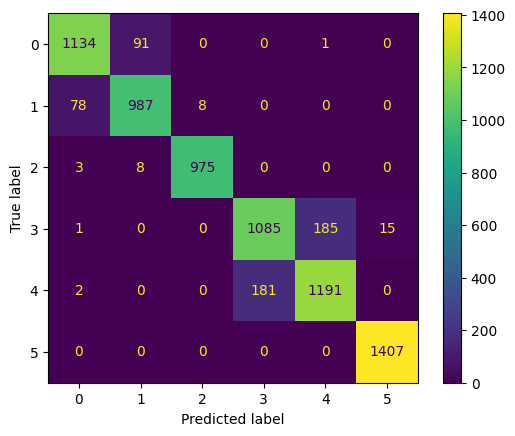

In [162]:
train_acc = train_sample_accuracy(fm)
train_acc

0.8924329826942654

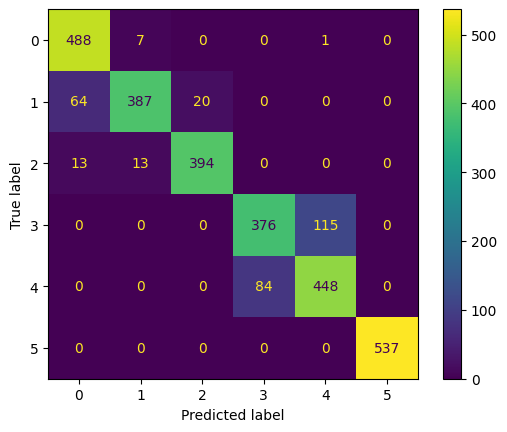

In [163]:
test_sample_accuracy(fm)

## LSTM weight aggregation

In [ ]:
class PDevLSTMAggregation(nn.Module):
    def __init__(
        self,
        dropout: float,
        input_dim: int,
        hidden_dim: int,
        out_dim: int,
        multidev_config: AttentionDevelopmentConfig,
    ):
        super().__init__()
        self.atdev = MultiheadAttentionDevelopment(
            dropout=dropout,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            multidev_config=multidev_config,
        )
        in_dim1 = (
            multidev_config.groups[0].channels * multidev_config.groups[0].dim ** 2
        )
        in_dim2 = (
            multidev_config.groups[1].channels * multidev_config.groups[1].dim ** 2
        )
        self.l1 = nn.Linear(in_dim1, out_dim)
        self.l2 = nn.Linear(in_dim2, out_dim)

    def forward_partial(self, x: Tensor):
        s1, s2 = self.atdev(x)
        return s1, s2

    def forward(self, x: Tensor):
        s1, s2 = self.atdev(x)
        y1 = self.l1(s1.view(len(s1), -1))
        y2 = self.l2(s2.view(len(s2), -1))
        return (y1 + y2) / 2.0

## CNN initial filter 
- make sure attention done on the right dimension (along the paths rather than accross the features)
- add initial 1-kernel CNN layer before attention